<a href="https://colab.research.google.com/github/mahessh/pm_portfolio/blob/main/WithRagGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to Lab 2
## Here we will solve the context length problem using RAG(Retrieval Augmented generation)

RAG involves the following steps:
1. Creating Chunks of the document.
2. Using these chunks to create vector db.
3. Using FAISS(Facebook AI Similarity Search) to search the closest vectors relative to the Question asked.

* Transformers: This is a large and convenient package, that has many libraries for loading models from huggingFace, fine tuning models, creating pipelines, loading tokenizers. This package is provided by Huggingface
* faiss-cpu: This package is used for generating the faiss index using CPU, search and indexing is also done by CPU.
* sentence-transformer: This well known package is used to transform sentences to embeddings.
* langchain: This is yet another large and powerfull library used for many things like splitting sentences into chunks, making calls to OpenAI. They also have their own FAISS indexing library but will not use it from Langchain but the faiss library itself.
* openai: This is used to call the openAI model.
* PyMuPDF: This package is used for easy PDF manipulation.
* tiktoken: This package is used to calculate the tokens in a text

In [ ]:
%%capture
!pip install transformers faiss-cpu sentence-transformers langchain==0.0.354 pypdf openai==1.3.9 PyMuPDF==1.24.2 tqdm tiktoken

In [ ]:
from transformers import pipeline,BertTokenizer
from sentence_transformers import SentenceTransformer,util
from langchain.text_splitter import RecursiveCharacterTextSplitter
import fitz
import faiss
import numpy as np
import openai
import numpy as np
import os
from tqdm import tqdm
import tiktoken

# As described in prerequiste step 1. Replace your OpenAPI key here.
os.environ["OPENAI_API_KEY"] = "<Place your OpenAI key here>"
model_name = "gpt-3.5-turbo"

token_encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

### Using the all-mpnet-base-v2 or all-MiniLM-L6-v2 models from huggingFace, the embeddings for the document text/chunks will be generated.

Both all-mpnet-base-v2 and all-MiniLM-L6-v2 are sentence-transformer models used for tasks like semantic search, clustering, and sentence embedding.

 all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality.

 * The input sentence is tokenized into smaller units (tokens), typically using a tokenizer specific to the model (e.g., BERT tokenizer).
 * Each token is converted into an initial vector representation (embedding) using an embedding layer.
 * The token embeddings are then passed through multiple transformer layers.
 * After passing through the transformer layers, the model generates contextualized embeddings for each token.
 * The final output is a fixed-size vector that represents the entire sentence in a high-dimensional space.

 ### Here's an overview of how embeddings are created (Images from ft.com):

 * This is a sentence

 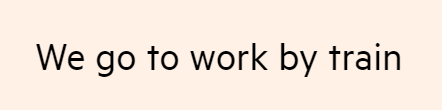
 * Break the sentence

 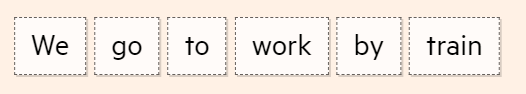
 * Compare with the existing information of sentences in the models memory
 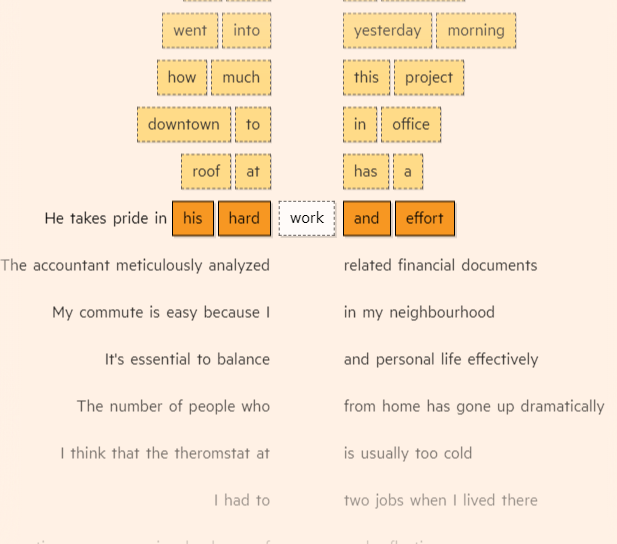
 * Assign vectors to them

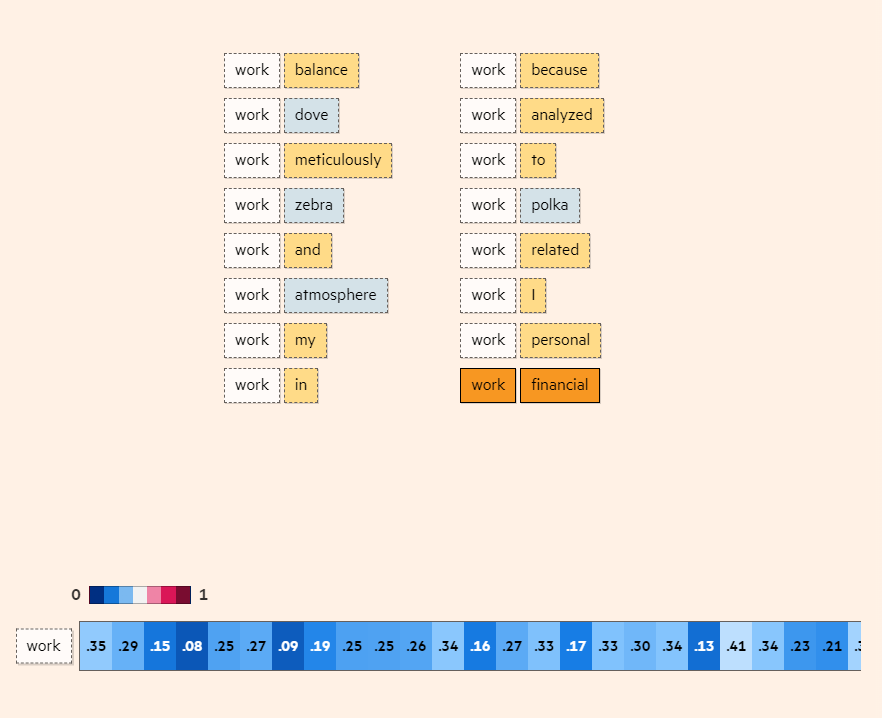
* Create the Vector DB that depends heavily on Clustering techniques
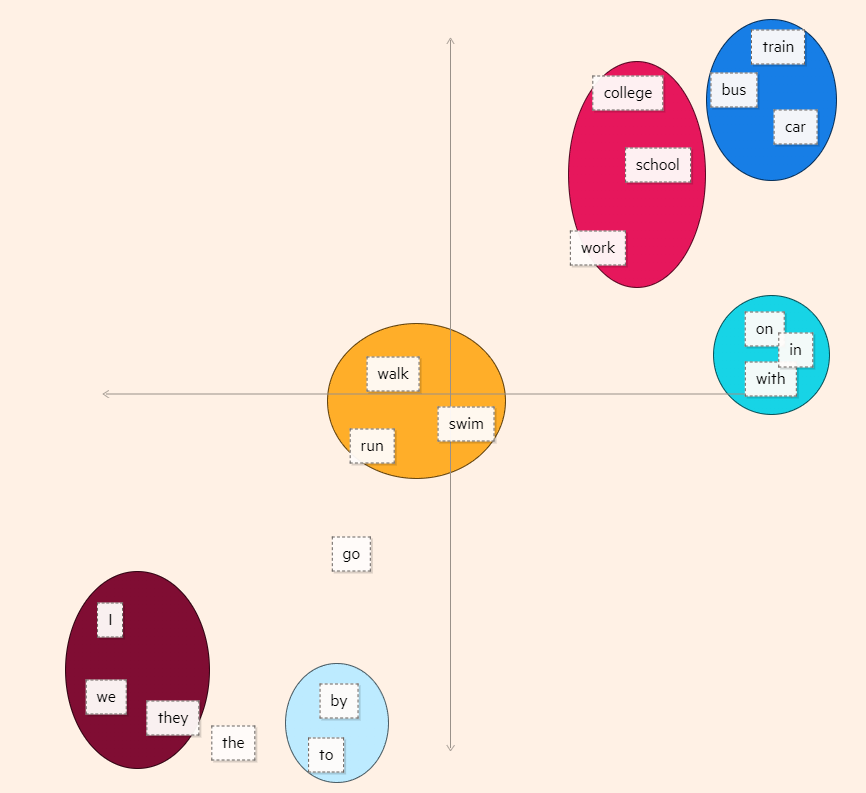
* Using the L2 Eucledian distance to find the lowest distance between the centroid of the clusters to our question.

In [ ]:
%%capture
encoder = SentenceTransformer("all-MiniLM-L6-v2")
# encoder = SentenceTransformer("allenai/longformer-base-4096")

### Loading the contents of a PDF and converting them to chunks to form the embeddings

Also upload the .PDF in the Colab runtime.

Follow the Instructions given in Lab-0 to where we have shown how to upload the files to the Colab runtime.

Here's the link:

https://github.com/initmahesh/MLAI-community-labs/blob/main/Class-Labs/Lab-0(Pre-requisites)/README.md

In [ ]:
pdf = "PROFRAC HOLDINGS, LLC credit agreement.pdf"

#### Making the chunks
This cell will mainly creates chunks using `RecursiveCharacterTextSplitter()` with `chunk_size` as 20 (20 words), `chunk_overlap` as 5 (5 words will always overlap).

In the `For loop` we are going through each page of the document and converting the content of each page to chunks and storing them in an array called the `knowledge_base`.

The `knowledge_base` is then converted to embedding indices.

#### Chunks are basically substrings of length 20

In [ ]:
knowledge_base = []
recursive_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 20,
    chunk_overlap = 5,
    length_function = len
)
file = fitz.open(pdf) # <------Make changes in the PDF file path that you want to use
for page in file:
  text = page.get_text()
  text = recursive_splitter.split_text(text)
  knowledge_base.append(text)

print(knowledge_base[:3])

[['EX-10.1 2', '2 d497551dex101.htm', 'EX-10.1', 'Exhibit 10.1', 'Execution Version', 'FOURTH AMENDMENT', 'TO TERM LOAN CREDIT', 'AGREEMENT', 'THIS FOURTH', 'AMENDMENT TO TERM', 'TERM LOAN CREDIT', 'AGREEMENT (this', '“Amendment”), dated', 'as of February 1,', '1, 2023, relating', 'to the', 'Credit Agreement', 'referred to below,', 'is made by and', 'and among PROFRAC', 'HOLDINGS II, LLC, a', 'a Texas limited', 'liability company', '(the “Borrower”),', 'PROFRAC HOLDINGS,', 'LLC, a Texas', 'limited liability', 'company', '(“Holdings”), the', 'the Guarantors', 'party hereto, each', 'each of the', 'the Additional Term', 'Term B Loan', 'Lenders (as defined', 'below), each of the', 'the other Lenders', 'party hereto, as', 'as required, as the', 'the case may be, by', 'by the terms of', 'of this Amendment', 'and the Existing', 'Credit Agreement,', 'and PIPER SANDLER', 'FINANCE LLC, as the', 'the Agent and the', 'the Collateral', 'Agent for the', 'the Lenders.', 'RECITALS', 'WHEREAS, the', 't

### This cell takes in the knowledge base and creates index/db of the embeddings
k_base is an array of chunks taken from a document

So, `encoder.encode(k_base)` will convert these chunks into continuous vectors

The vectors are flattened in a single row array using `vectors.shape[1]`

Using `index = faiss.IndexFlatL2(vector_dimension)` Eucledian L2 distance the `faiss` vector is created.

Index is normalized to be within the range of 0-1 using `faiss.normalize_L2(vectors)`

The vector embedding are created in this way (Image Referenced from PineCone)

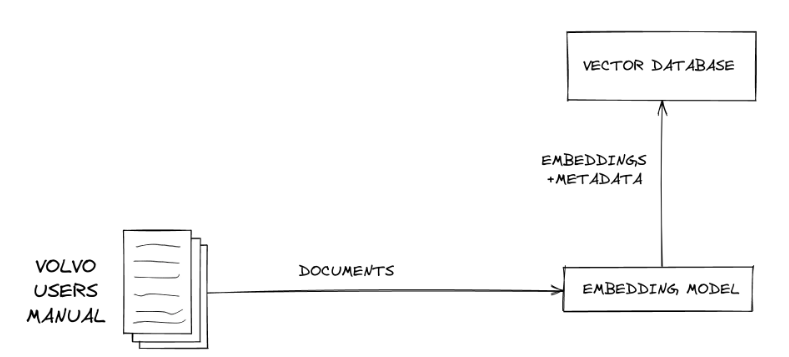

In [ ]:
vectors = encoder.encode(knowledge_base)
vector_dimension = vectors.shape[1]
embed_index = faiss.IndexFlatL2(vector_dimension)
faiss.normalize_L2(vectors)
embed_index.add(vectors)

In [ ]:
print(vectors)

[[-0.1032218   0.01374095 -0.00304347 ...  0.07314894 -0.0772576
  -0.01191116]
 [ 0.06253488  0.04715158  0.01991874 ... -0.03162443  0.12144919
  -0.00372378]
 [ 0.0108228   0.05305075 -0.03286663 ... -0.10870761  0.09666455
  -0.00621681]
 ...
 [-0.07770729  0.11904879  0.08479485 ...  0.03713319 -0.07278096
  -0.04879091]
 [ 0.01468012  0.00854761  0.01200565 ...  0.01782701  0.08919922
   0.07142419]
 [-0.04302358 -0.02599827 -0.01586002 ... -0.00531212 -0.02143622
  -0.07496252]]


### The answer_question() function takes the question, the array of embeddings and the number of results wanted, then searches the array that best fits the questions.

In this function:

1. The question is encoded to create a matrix of vectors that is flattened to 1-D array and normalized.
2. `index.search(_vector, results_len)` will return the distaces and the array of most relevant chunks indexes.
3. We us the retrieved indexes to get the values from `knowledge_base[]`.
4. `retrieved_idxs.ravel()[i]` converts the 2-D array into 1-D by flattening it.
5. `answer` stores array of chunks that are most relevant.

In [ ]:
def answer_question(question,index,results_len):
  answer = []
  """
  This function takes a question and uses RAG to answer it with Faiss for retrieval.

  Args:
      question: The user's question as a string.

  Returns:
      A dictionary containing the answer and retrieved passage.
  """
  search_vector = encoder.encode(question)
  _vector = np.array([search_vector])
  faiss.normalize_L2(_vector)

  # # # Encode the question
  # question_encoding = tokenizer(question, return_tensors="pt",truncation=True,padding=True)["input_ids"]
  # # Retrieve relevant passages using Faiss
  # question_vec = question_encoding.cpu().numpy()
  distances, retrieved_idxs = index.search(_vector, results_len)
  print(len(retrieved_idxs.ravel()))
  # Extract the answer and passage based on the retrieved index
  for i in range(len(retrieved_idxs.ravel())):
    answer.append(knowledge_base[retrieved_idxs.ravel()[i]])

  # Return the answer and retrieved passage for transparency
  return {"answer": answer}

### Generating the answers/chunks related to the question from the array of embeddings

In this function we are getting the relevant chunks using the question that the user provided.`answer_question(question,embed_index,10)`

In the `For Loop` we are interating through each chunk and enclosing them inside tags as `<ContextN></ContextN>`

These chunks are then returned

In [ ]:
def return_RAG_passage(question,embed_index,chunk_number):
  RAG_passage = ''
  answer_dict = answer_question(question,embed_index,chunk_number)
  for i in range(len(answer_dict['answer'])):
    RAG_passage += '<Context'+str(i)+'>'+' '.join(answer_dict['answer'][i])
    RAG_passage += '</Context'+str(i)+'>'+'\n\n'

  print(RAG_passage)
  return RAG_passage

This is how we inference using GPT models (Image Referenced from PineCone)

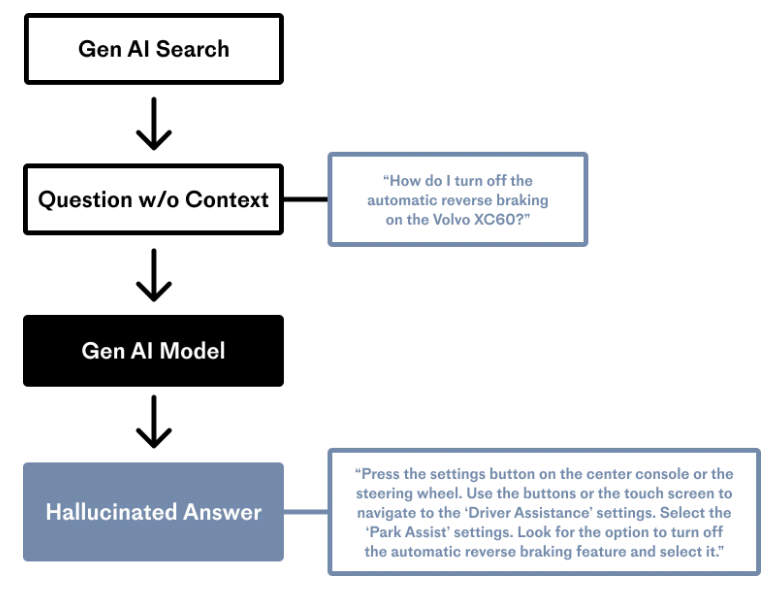



## Here we are creating this function which is called to generate results using the `openai.chat.completions.create`

**Experiment with you own values of temperature and top_p**

In [ ]:
def CallOpenAI(user,system):
  response = openai.chat.completions.create(
              model= model_name, # model = "deployment_name".
              temperature= 0,
              top_p= 0,
              messages=[
                  {"role": "system", "content": system},
                  {"role": "user", "content": user}
              ]
          )
  return response

## We are formatting the RAG chunks to be included in the `<Context>` tag

### We also format the prompt to include the RAG chunks along with the question
### What happens in the Background?

The most relevant chunks are retrieved from the vector index and these chunks are formatted to be included between:

`<Context1></Context1>`

`<Context2></Context2>`

.

.

.

`<ContextN></ContextN>`

Also you can change the number of RAG chunks you want to send as context to the GPT.

Change it here in the cell below:

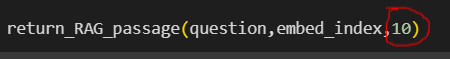

Also you can change the number of RAG chunks you want to send as context to the GPT.

Change it here in the cell below:

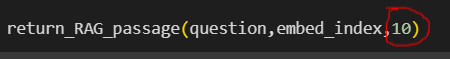

From here the following function is called:

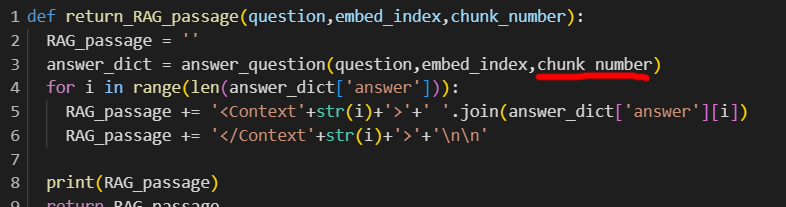

From there the `answer_question()` function is called:

Here while searching the index for relevant chunk, only the specified number of chunks are retrieved.

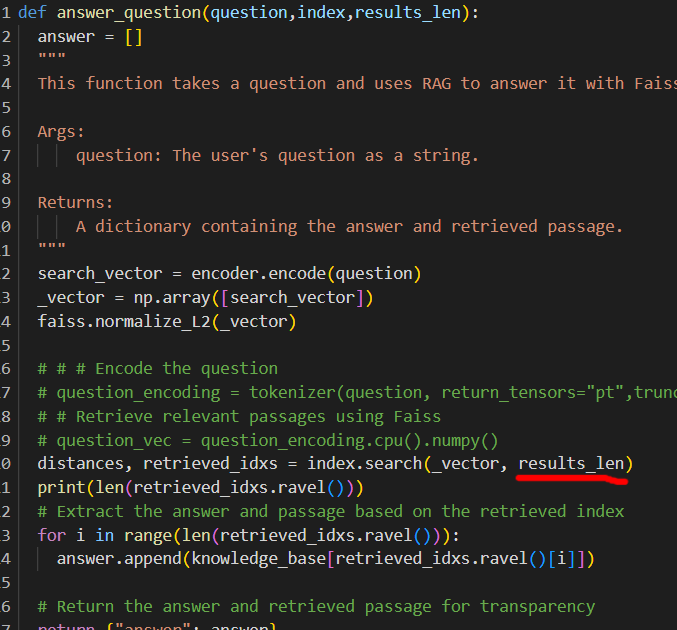

## Here is what happens in the background when a search value is passed in `index.search(vector,search value)`

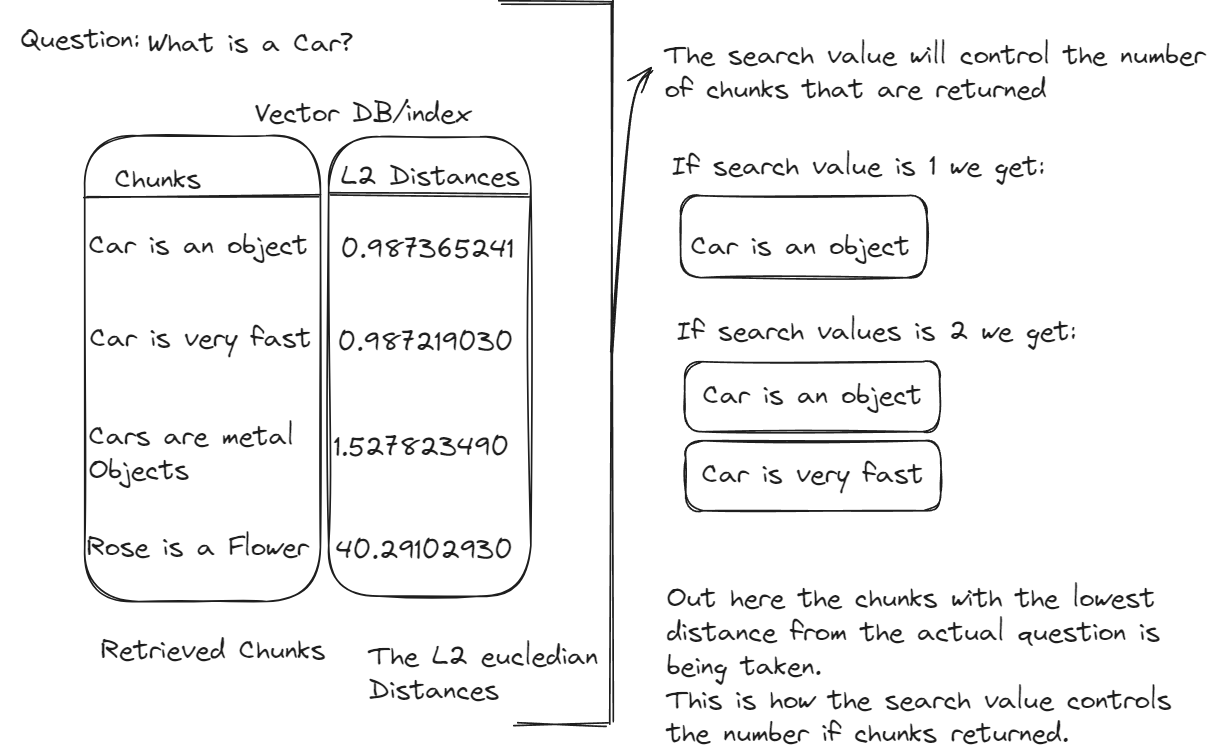

This is how the chunks are retrieved (Image Referenced from PineCone)

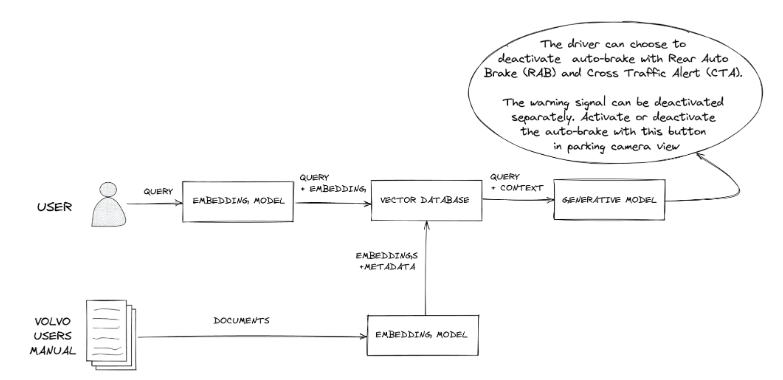

In [ ]:
question = "What is the Acknowledgement Regarding Any Supported QFCs?"

rag_passage = return_RAG_passage(question,embed_index,10)

10
<Context0>7.23  FCPA
   118 7.24  Sanctioned Persons 118 7.25  Designation of Senior Debt 118 7.26  Insurance 118 7.27  FTS Assets 118 ARTICLE VIII AFFIRMATIVE AND AND NEGATIVE COVENANTS 8.1   Taxes 118 8.2   Legal Existence and Good Good Standing 119 8.3   Compliance with Law; Law; Maintenance of of Licenses 119 8.4   Maintenance of Property, Inspection 119 8.5   Insurance 120 8.6   Environmental Laws 121 8.7   Compliance with ERISA 121 8.8   Dispositions 121 8.9   Mergers, Consolidations, etc 121 8.10  Distributions 122 8.11  Investments 126 
8.12  Debt 126 8.13  Prepayments of Debt 130 8.14  Transactions with Affiliates 131 8.15  Business Conducted 134 
8.16  Liens 134 8.17  Restrictive Agreements 134 8.18  Restrictions on FTS Acquisition Transactions 136 8.19  Fiscal Year; Accounting 136 8.20  Financial Covenants 137 8.21  Information Regarding Collateral 138 8.22  Ratings 138 8.23  Additional Obligors; Covenant to Give Security 138 8.24  Use of of Proceeds 140 8.25  Further Ass

## Adding the question to the RAG chunks,

### Also you can see that the token count has decreaded significantly to 8347, which was 163227 before.

Finally this is how we combine the chunks and the questions to get the results
(Image Referenced from PineCone)

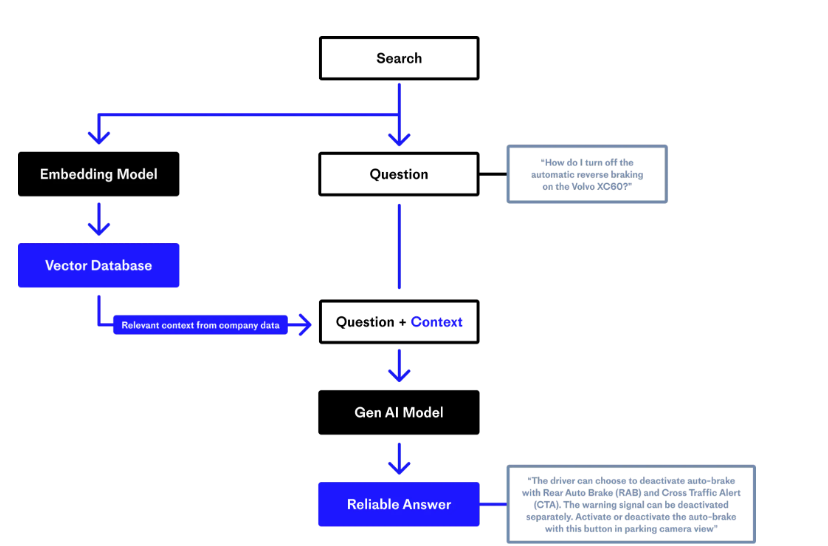

In [ ]:
full_prompt_LD = rag_passage +"\n\n" +question
print(len(token_encoding.encode(full_prompt_LD)))

8347


In [ ]:
response = CallOpenAI(full_prompt_LD,"You are a Professional lawyer who can analyse documents thorougly")

### Finally you get the answer which was throwing error in our previous lab

In [ ]:
print(response.choices[0].message.content)

The "Acknowledgement Regarding Any Supported QFCs" is a provision in a legal document that addresses the treatment of hedge agreements or other agreements or instruments that are qualified financial contracts (QFCs) and are supported by the loan documents. 

In this provision, the parties acknowledge and agree to certain aspects related to the resolution power of the Federal Deposit Insurance Corporation (FDIC) under the Federal Deposit Insurance Act and Title II of the Dodd-Frank Wall Street Reform and Consumer Protection Act. Specifically, it outlines the effects of a potential Bail-In Action on any liabilities arising from the QFCs, including potential reductions, conversions into shares or other instruments of ownership, or variations in terms of such liabilities.

The provision also addresses the treatment of Supported QFCs in the event of a proceeding under a U.S. Special Resolution Regime, where the transfer of such Supported QFCs and QFC Credit Support would be effective to the

## Appendix
Try how chuck split works here : https://langchain-text-splitter.streamlit.app/

How RAG works theory : https://www.pinecone.io/learn/retrieval-augmented-generation/


Good explanation on how embedding work : https://ig.ft.com/generative-ai/

